# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re
from lightgbm import LGBMClassifier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews = df_reviews.dropna()

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

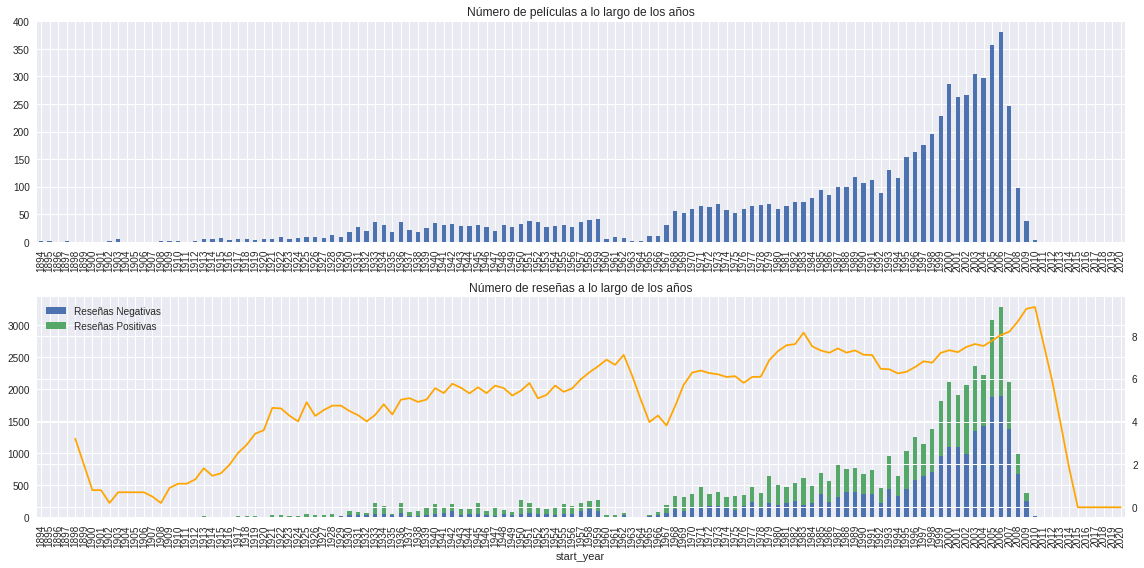

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Agregar leyendas personalizadas
dft2.plot(kind='bar', stacked=True, ax=ax)

# Calcular y agregar la media móvil
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reseñas por película (promedio móvil de 5 años)', ax=axt)

# Crear una leyenda personalizada
ax.legend(['Reseñas Negativas', 'Reseñas Positivas'], loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**OBSERVACIONES:** En el primer grafico podemos ver como a lo largo de los años tenemos una cantidad mayor de reseñas en el conjunto de datos que nosotros estamos utilizando para realizar esta investigación. De la misma forma podemos ver en el grafico de abajo que la media movil aumenta a medida que avanzamos en el tiempo. Tambien en el grafico de abajo, se muestra la distribución de reseñas clasificadas como positivas y negativas a lo largo de los años. Las barras de color verde representan las reseñas positivas y podemos observar como tenemos una altura mayor en las barras verdes sobre las barras azules que representan las reseñas negativas, el hecho de que las barras tengan una altura mayor representa una frecuencia mayor lo que nos indica que con mas frecuencia hay mas reseñas positivas que negativas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

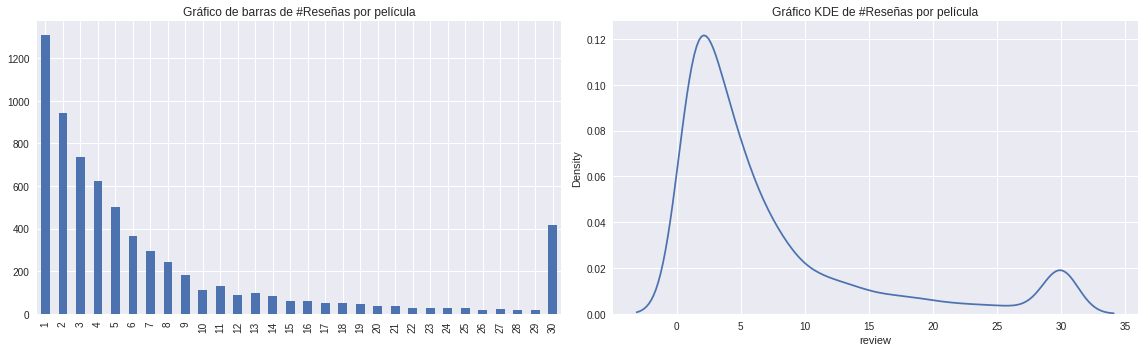

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**OBSERVACIONES:** Podemos ver en estos graficos que es muy comun que para las peliculas solo tengamos una reseña y pues claramente es muy poco comun que tengamos mas reseñas, pues esto requeriria de que mas personas escribieran mas reseñas y es mucho mas comun solo tener una reseña de una pelicula que 20 reseñas por que claramente es mas facil tener solo una reseña que a tener 20 reseñas.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

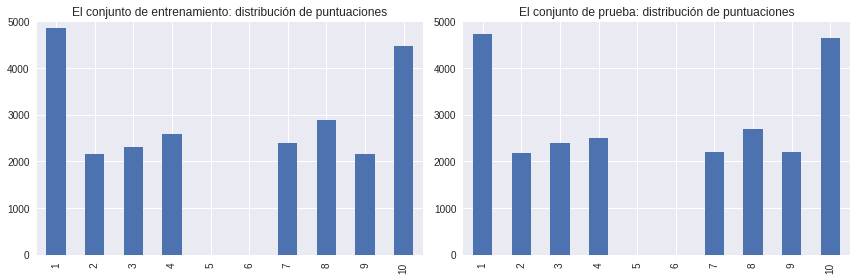

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**OBSERVACIONES:** En este graico podemos visualizar la distribuciones que tenemos para el conjunto de entrenamiento y el conjunto de prueba. Gracias a esto podemos evaluar el equilibrio que tenemos en nuestros datos y claramente podemos ver que tienen una distribucion son muy similar lo cual es bueno y da una buena señal de que tenemos un buen equilibrio en nuestros datos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


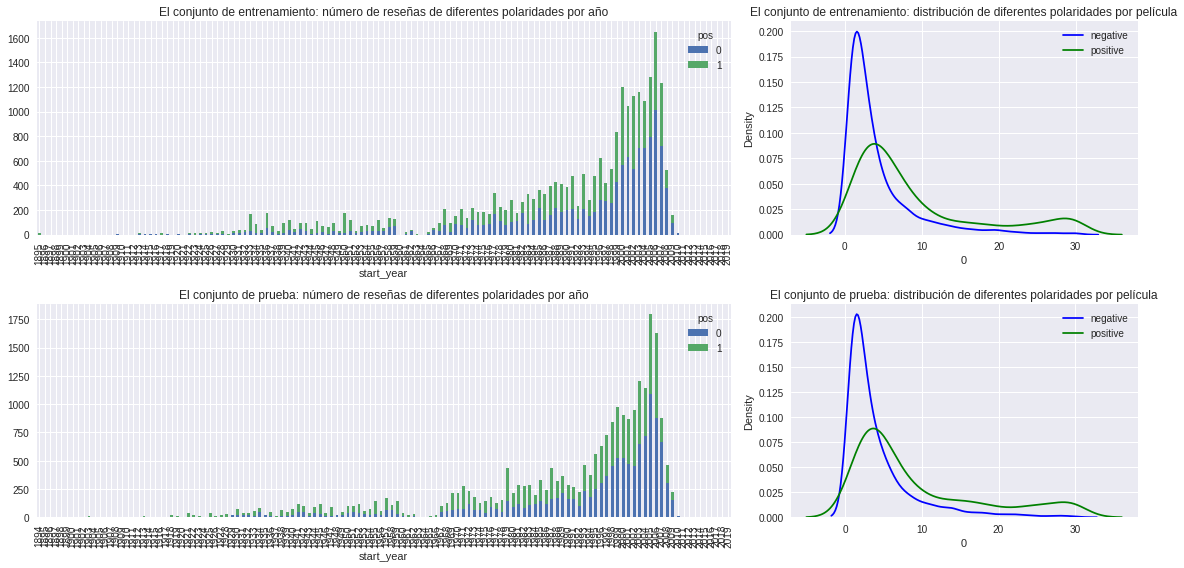

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**OBSERVACIONES:** Es muy interesante lo que podemos ver en estas graficas. Del lado izquierdo podemos ver El numero de reseñas de diferentes polaridades por año y claramente podemos ver que hay una cantidad mayor de reseñas positivas que son representadas por el color verde. Del lado derecho podemos ver la distribución de diferentes polaridades por pelicula y llegariamos a creer que la grafica esta mal por que, que no se suponia que habian mas reseñas positivas que negativas?(En otras palabras, no se suponia que la linea verde iba a estar por encima de la linea azul?) Eso es correcto y eso es lo que las graficas de la derecha representan, pues podemos ver que al inicio habian muchas reseñas en un pequeño intervalo pero si vemos la grafica a largo plazo podemos ver que a medida que aumenta el numero de reseñas en el grafico, podemos ver como la linea verde que representa las reseñas positivas esta siempre por encima de la linea azul que representa las reseñas negativas. Esto quiere decir que a medida que tenemos una cantidad mayor de reseñas tenemos una cantidad mayor de reseñas positivas y solamente cuanto tuvimos una cantidad pequeña de reseñas obtuvimos mas reseñas negativas que positivas. Esto tiene mucho sentido debido a que puedes tener 6 reseñas negativas en el numero de reseñas 1, lo que da un total de 6 reseñas negativas, pero si por ejemplo tenemos 2 reseñas negativas en el numero 4 de reseñas, pues al multiplicar 2 por 4 podemos ver que es un 8 lo que representa que tenemos 8 reseñas postivas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
# Inicializaremos el lematizador y las stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())  # Tokenizar el texto y hacer minusculas
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lematizar cada token
    return ' '.join(lemmatized_tokens)  # Unir los tokens lematizados de nuevo en un texto

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Eliminar dígitos
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clean_text).apply(lemmatize_text)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
# Declaramos las variables que necesitaremos para poder entrenas a nuestro modelo y ponerlo a prueba.

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [16]:
# Inicializar el modelo constante
modelo_constante = DummyClassifier(strategy='constant', constant=1)

# Entrenar el modelo constante
modelo_constante.fit(df_reviews_train['review_norm'], train_target)

# Predecir las etiquetas en el conjunto de datos de prueba
y_pred = modelo_constante.predict(df_reviews_test['review_norm'])

# Calcular el puntaje F1
f1_constante = f1_score(test_target, y_pred, average='binary')

print("Puntaje F1 del modelo constante:", f1_constante)

Puntaje F1 del modelo constante: 0.6652865609846014


**OBSERVACIONES:** Este modelo solo lo estamos utilizando para hacer una prueba de cordura y podemos verlo claramente al obtener un valor de 0.66, utilizaremos este valor para poder compararlo con el valor que ontengamos de nuestros proximos modelos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [17]:
# Definir vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, preprocessor=lemmatize_text)

# Entrenar vectorizador TF-IDF y transformar los datos de entrenamiento
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])

# Transformar los datos de prueba utilizando el mismo vectorizador TF-IDF
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# Inicializar el clasificador de Regresión Logística
model_1 = LogisticRegression()

# Entrenar el clasificador de Regresión Logística
model_1.fit(train_features_1, train_target)

# Predecir las etiquetas en el conjunto de datos de prueba
y_pred_1 = model_1.predict(test_features_1)

# Calcular el puntaje F1
f1_model_1 = f1_score(test_target, y_pred_1, average='binary')

print("Puntaje F1 del Modelo 1 (NLTK, TF-IDF y LR):", f1_model_1)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Puntaje F1 del Modelo 1 (NLTK, TF-IDF y LR): 0.8786767840395601


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


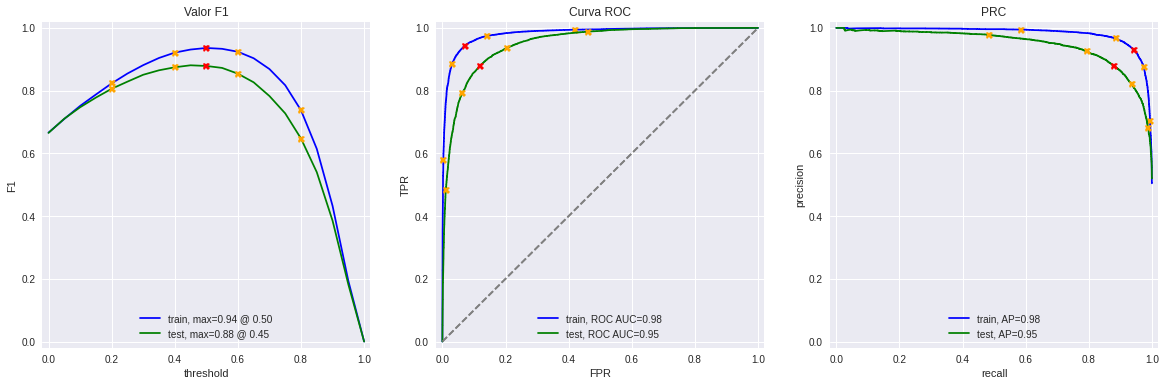

In [18]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**OBSERVACIONES:** Excelente pasamos la prueba de cordura, nuestro modelo obtuvo una calificaion mas alta que el 0.66 y todavia aun logro superar el 0.85 de calificación que se nos pedia. Para este modelo utilizamos la Regresion Logistica y el Natural Language Tokenizer.

### Modelo 2 - spaCy, TF-IDF y LR

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop] # Lematizar el texto
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [21]:
# Definir vectorizador TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(preprocessor=text_preprocessing_3)

# Entrenar vectorizador TF-IDF y transformar los datos de entrenamiento
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm'])

# Transformar los datos de prueba utilizando el mismo vectorizador TF-IDF
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm'])

# Inicializar el clasificador de Regresión Logística
model_2 = LogisticRegression()

# Entrenar el clasificador de Regresión Logística
model_2.fit(train_features_3, train_target)

# Predecir las etiquetas en el conjunto de datos de prueba
y_pred_3 = model_2.predict(test_features_3)

# Calcular el puntaje F1
f1_model_3 = f1_score(test_target, y_pred_3, average='binary')

print("Puntaje F1 del Modelo 3 (spaCy, TF-IDF y LR):", f1_model_3)

Puntaje F1 del Modelo 3 (spaCy, TF-IDF y LR): 0.8805111821086262


**OBSERVACIONES:** Hasta el momento este es nuestro mejor modelo con un valor f1 de `0.88`, para este modelo utilizamors Spacy y una Regresion Logistica.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [22]:
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]  # Lematizar el texto
    return ' '.join(tokens)

# Definir vectorizador TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(preprocessor=text_preprocessing_4)

# Entrenar vectorizador TF-IDF y transformar los datos de entrenamiento
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_norm'])

# Transformar los datos de prueba utilizando el mismo vectorizador TF-IDF
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_norm'])

# Inicializar el clasificador LGBMClassifier
model_3 = LGBMClassifier()

# Entrenar el clasificador LGBMClassifier
model_3.fit(train_features_4, train_target)

# Predecir las etiquetas en el conjunto de datos de prueba
y_pred_4 = model_3.predict(test_features_4)

# Calcular el puntaje F1
f1_model_4 = f1_score(test_target, y_pred_4, average='binary')

print("Puntaje F1 del Modelo 4 (spaCy, TF-IDF y LGBMClassifier):", f1_model_4)

Puntaje F1 del Modelo 4 (spaCy, TF-IDF y LGBMClassifier): 0.859568357477721


**OBSERVACIONES:** En este momento este es nuestro modelo en tercer lugar despues del primer modelo que creamos, para este modelo nosotros utilizamos Spacy pero ahora lo usamos en un modelo LGBMClassifier y obtuvimos un valor de `0.86`. El uso de gráficos para evaluar la presencia de sobreajuste fue fundamental para comprender la generalización del modelo. Observamos que el modelo parece generalizar bien a partir de los gráficos, lo que indica que no hay evidencia de sobreajuste en este caso particular.

## Mis reseñas

In [23]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# Definir las funciones de limpieza y lematización
def lemmatize_text(text):
    tokens = word_tokenize(text.lower())  # Tokenizar el texto y hacer minúsculas
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lematizar cada token
    return ' '.join(lemmatized_tokens)  # Unir los tokens lematizados de nuevo en un texto

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Eliminar dígitos
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    return text

# Normalizar las reseñas en my_reviews
my_reviews['review_norm'] = my_reviews['review'].apply(clean_text).apply(lemmatize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i wa bored and felt asleep in the middle ...
2,I was really fascinated with the movie,i wa really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor looked really old and disintere...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had it upside and downside but i fee...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix wa a brave move i really ...


### Modelo 1

In [24]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.16:  well i wa bored and felt asleep in the middle of the movie
0.50:  i wa really fascinated with the movie
0.13:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.25:  i didnt expect the reboot to be so good writer really cared about the source material
0.54:  the movie had it upside and downside but i feel like overall it a decent flick i could see myself go
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid won
0.88:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


**OBSERVACIONES:** Podemos ver que nuestro modelo funciona muy bien. Hay que recordar que los valores que tengamos cercanos a 0 quiere decir que nuestro modelo esta prediciendo que esa reseña es negativa y entre el numero sea mas cercano a 1 representa que es una reseña positiva. en este caso al analizar podemos ver que nuestras predicciones son muy buenas, quizas una de las predicciones que podia haber sido mejor es el 0.50 y hubiera sido mejor si tuviera un valor mas alto.

### Modelo 2

In [25]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.19:  well i wa bored and felt asleep in the middle of the movie
0.45:  i wa really fascinated with the movie
0.16:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.20:  i didnt expect the reboot to be so good writer really cared about the source material
0.71:  the movie had it upside and downside but i feel like overall it a decent flick i could see myself go
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid won
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


**OBSERVACIONES:** Muy bien podemos ver que este modelo es un poco mas extremista, en comparacion con el modelo anterior que nos dio varios valores cercanos al 0.50 este nos dio valores muy altos oh muy bajos, lo cual ayuda a ser mas precisos. Una de las cosas en las que puede mejorar es que hubieron algunas reseñas que debieron haber tenido una calificacion mas alta como el .45 que obtuvimos de la tercer reseña.

### Modelo 3

In [26]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  i did not simply like it not my kind of movie
0.47:  well i wa bored and felt asleep in the middle of the movie
0.57:  i wa really fascinated with the movie
0.63:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.40:  i didnt expect the reboot to be so good writer really cared about the source material
0.73:  the movie had it upside and downside but i feel like overall it a decent flick i could see myself go
0.30:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid won
0.75:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


**OBSERVACIONES:** Como bien sabemos este era nuestro modelo con el valor f1 mas bajo y se ve claramente reflejado en nuestras predicciones pues podemos ver que sus predicciones son muy cercanas al 0.50 lo cual nos da menos precision para determinar si la reseña analizada es negativa oh positiva. Por lo tanto podemos decir que este modelo es el que menos nos sirve de los demas por que valores que deberia de clasificar como mas positivos oh mas negativos los suele dejar mur vervas del 0.50 lo cual no nos ayuda de mucho.

## Conclusiones

In [27]:
resultados = {
    'Modelo': ['Modelo2-spaCy,TF-IDF y LR', 'Modelo1-NLTK,TF-IDF y LR',  'Modelo3-spaCy,TF-IDF y LGBMClassifier'],
    'F1_Score' : [0.88, 0.87, 0.85]  
}

df_resultados = pd.DataFrame(resultados)

display(df_resultados)

,Modelo,F1_Score
0,"Modelo2-spaCy,TF-IDF y LR",0.88
1,"Modelo1-NLTK,TF-IDF y LR",0.87
2,"Modelo3-spaCy,TF-IDF y LGBMClassifier",0.85


De este proyecto me gustaria destacar 3 puntos principales que son los siguientes:

1. Nuestro modelo con mejor calificacion F1 es Modelo2-spaCy,TF-IDF con una califiación de 0.88.
2. Si nuestras predicciones son correctas es preferible que tengan valores mas cercanos al 0 o al 1 que estar cerca al 0.50.
3. Es importante visualizar con tiempo el equlibrio de clases en nuestro conjunto de datos para posteriormente saber de que forma trabajar.